## A/B Testing

This is an a/b testing process of a new webpage, based on **convertion rate**.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A Conversion rate is a metric, shown as a percentage, that displays how many website or app visitors complete an action out of the total number of visitors.

This dataset simulates a learning website which is to implement a new page design for one of their courses. And want to measure how the new page affected their convertion rate before making the decision to implement it.

The goal of this a/b test is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
#importing necessary libraries 

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Reading and assessing data:

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df.groupby('user_id').converted.sum().mean()

0.12126269856564711

The number of times the `new_page` and `treatment` don't match.

In [6]:
gb_obj = df.groupby(['group','landing_page']).count()
gb_obj

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [7]:
gb_obj.loc[[('control','new_page'),('treatment','old_page')],:].user_id.sum()

3893

Checking for missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# Dropping rows with wrong values
index1 = ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))

df2 = df.drop(df[index1].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

Checking for duplicates:

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2[df['user_id'] == 773192]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
index = df2[df2.user_id.duplicated()].index

In [15]:
df2.drop(index,inplace=True)

In [16]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


The probability of an individual converting regardless of the page they receive.

In [17]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_p = df2[df['group'] == 'control'].converted.mean()
control_p

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_p = df2[df['group'] == 'treatment'].converted.mean()
treatment_p

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.11880806551510564

The probability that an individual received the new page:

In [20]:
groupby_page = df2.groupby('landing_page').user_id.count()
groupby_page.loc['new_page'] / groupby_page.sum()

0.50006194422266881

### Summary I
**Preliminary analysis doesn't show any evidence that the new treatment page leads more converts.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` Our assumptions for null and alternative hypotheses.

**$H_0 : p_{new} - p_{old} \leq 0 $** <br>
**$H_1 : p_{new} - p_{old} > 0 $**

`2.` Assuming under the null hypothesis, both ($p_{new}$ and $p_{old}$) are the same, and both are equal to the overall conversion rate.

**Conversion rate** for $p_{new}$ and $p_{old}$ under the null? 

In [21]:
p_new = df2.converted.mean()

In [22]:
p_old = df2.converted.mean()

Calculating the number of individuals in each group:

In [23]:
n_new = df2[df2.group == 'treatment'].user_id.nunique()

In [24]:
n_old = df2[df2.group == 'control'].user_id.nunique()

Simulating null hypothesis 10,000 times to achieve accurate results:

In [29]:
p_diffs = np.array([])
for i in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new, p_new]).mean()
    old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old, p_old]).mean()
    p_diffs = np.append(p_diffs, (new_page_converted - old_page_converted))

Plotting the result:

In [30]:
actual_p_diff = treatment_p - control_p
actual_p_diff

-0.0015782389853555567

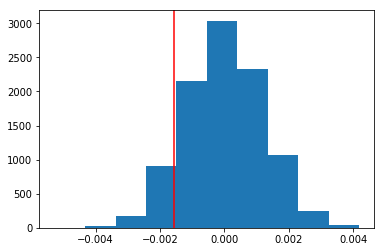

In [31]:
plt.hist(p_diffs)
plt.axvline(actual_p_diff, color='red')

P value:

In [32]:
p = (p_diffs > actual_p_diff).mean()
p

0.9012

### Summary II
**Resulting $p$ value is $0.91$, which is much greater than our significance level ($\alpha = 0.05$), thus, we fail to reject null hypothesis.** <br> **In other words, the previous analysis didn't show any significant increase in conversion rate in users who experienced the new page in comparison to users who experienced the old one.**

**Another way** to do the testing using statsmodels:

In [33]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
statistic, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
statistic, p_value

(1.3109241984234394, 0.90505831275902449)

**We fail to reject null hypothesis as  $z-score = 1.3109$  which is lower than the critical value $(1.6449)$.** <br> **Also $p = 0.90$ which is much greater than our significance level ($\alpha = 0.05$).**

<a id='regression'></a>
### Part III - A regression approach

`1.` Result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**Logistic regression.**

In [35]:
#Creating intercept

df2['intercept'] = 1

df2[['ab_page', 'old']] = pd.get_dummies(df2['landing_page'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [36]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [37]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        13:47:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

P value this time is different as we are using different hypotheses:

**$H_0 : p_{old} = p_{new}$** <br> **$H_1 : p_{old} \neq p_{new}$**

**Adding a predictor with strong correlation can have significant effect on our model performance. Features such as country, age, gender, and time may have a role in predicting our dependant variable.<br> However, adding many features with multicollinearity may have negative impact on our model so we should make sure to check variables before adding them. Also dealing with many features may require higher computational resources so we should make sure to choose the most important ones.**

adding an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together datasets on the appropriate rows. 

In [39]:
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [41]:
df3 = df2.merge(country, on='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [42]:
dumm = pd.get_dummies(df3.country)
df3 = df3.join(dumm)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [48]:
df3['intercept'] = 1

lm = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'US', 'UK']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        13:51:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [51]:
#adding interaction columns
df3['ab_page_US'] = df3['ab_page'] * df3['US']
df3['ab_page_UK'] = df3['ab_page'] * df3['UK']

#fitting model
lm = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'US', 'UK', 'ab_page_US', 'ab_page_UK']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 28 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        13:52:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

In [66]:
#calculating coefficients
1/np.exp(-0.0674), np.exp(0.0175), np.exp(0.0118), np.exp(0.0469), np.exp(0.0783)

(1.0697232819209153,
 1.0176540221507617,
 1.011869894648401,
 1.0480172021191829,
 1.0814470441230692)

<a id='conclusions'></a>

**Our model summary results suggest that users who were displayed the old page are $1.07$ times more likely to convert compared to users who were shown the new page.
Users from US and UK are $1.02$, $1.01$ times more likely to convert, respectively, compared to users from Canada. While holding all other variables are constant.**

**Users who were displayed the new page and are from US or UK are $1.05, 1.08$ times respectively more likely to convert, compared to baseline, while holding all other variables constant.**

**Although these results can be very helpful in predicting user behaviour, they are not significant as they didn't meet our significance level of $(\alpha = 0.05)$, gathering more related features can help in improving our model accuracy.**